In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Dynamically add project root to sys.path
PROJECT_ROOT = os.path.abspath("..")  # Adjust if necessary
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Verify sys.path
print("Project root added to sys.path:", PROJECT_ROOT)

from utils.config import *


plt.rcParams.update({
    'axes.titlesize': 22,            # Font size for the plot titles
    'axes.labelsize': 20,            # Font size for the x and y labels
    'legend.fontsize': 16,           # Font size for the legend
    'xtick.labelsize': 20,           # Font size for the x-tick labels
    'ytick.labelsize': 20,           # Font size for the y-tick labels
    'axes.linewidth': 3.5,           # Width of the axes' lines
    'xtick.major.width': 3.25,       # Width of the major x-tick lines
    'ytick.major.width': 3.25,       # Width of the major y-tick lines
    'xtick.minor.width': 4.0,        # Width of the minor x-tick lines
    'ytick.minor.width': 4.0,        # Width of the minor y-tick lines
    'figure.titlesize': 20,          # Font size for figure titles
    'legend.handlelength': 2,        # Length of the legend lines
    'legend.handleheight': 0.7,      # Height of the legend markers
    'legend.labelspacing': 0.5,      # Vertical spacing between legend entries
    'lines.linewidth': 3.0,          # Line width for plot lines
    'lines.markersize': 3,           # Size of markers in plot lines
    'axes.grid': False,               # Enable grid on all plots
    'grid.alpha': 0.75,              # Set gridline transparency
    'grid.linestyle': '--',          # Set gridline style
    'grid.linewidth': 0.7,           # Set gridline width
    'grid.color': 'gray',            # Set gridline color
})

Project root added to sys.path: /feynman/work/dap/lcs/vt272285/Generative modelling of convergence map
Global imports loaded successfully!


In [3]:
def load_takahashi_file(filename):
        skip = [0, 536870908, 1073741818, 1610612728, 2147483638, 2684354547, 3221225457]
        load_blocks = [skip[i+1]-skip[i] for i in range(0, 6)]
        with open(filename, 'rb') as f:
            rec = np.fromfile(f, dtype='uint32', count=1)[0]
            nside = np.fromfile(f, dtype='int32', count=1)[0]
            npix = np.fromfile(f, dtype='int64', count=1)[0]
            rec = np.fromfile(f, dtype='uint32', count=1)[0]
            print("nside:{} npix:{}".format(nside, npix))

            rec = np.fromfile(f, dtype='uint32', count=1)[0]
            print("file opened!")
            kappa = np.array([])
            r = npix
            for i, l in enumerate(load_blocks):
                blocks = min(l, r)
                load = np.fromfile(f, dtype='float32', count=blocks)
                np.fromfile(f, dtype='uint32', count=2)
                kappa = np.append(kappa, load)
                r = r-blocks
                if r == 0:
                    break
                elif r > 0 and i == len(load_blocks)-1:
                    load = np.fromfile(f, dtype='float32', count=r)
                    np.fromfile(f, dtype='uint32', count=2)
                    kappa = np.append(kappa, load)

        # nside_takahashi = new_nside
        # kappa_1024 = hp.pixelfunc.ud_grade(kappa, nside_takahashi)
        return kappa
    
def downgrage_map(map, nside):
    return hp.pixelfunc.ud_grade(map, nside)

def get_cls_from_map(map, nside, lmax):
    return hp.anafast(map, lmax=lmax, pol=True, use_pixel_weights=True)

def get_pixel_wf_ells(nside, lmax):
    ells = np.arange(lmax+1)
    pw =  hp.pixwin(nside, lmax=lmax)
    return pw, ells

def get_cls(map, lmax):
    return hp.anafast([map], pol=True, lmax=lmax, use_pixel_weights=True)


nside:4096 npix:201326592
file opened!
3.435486411817406


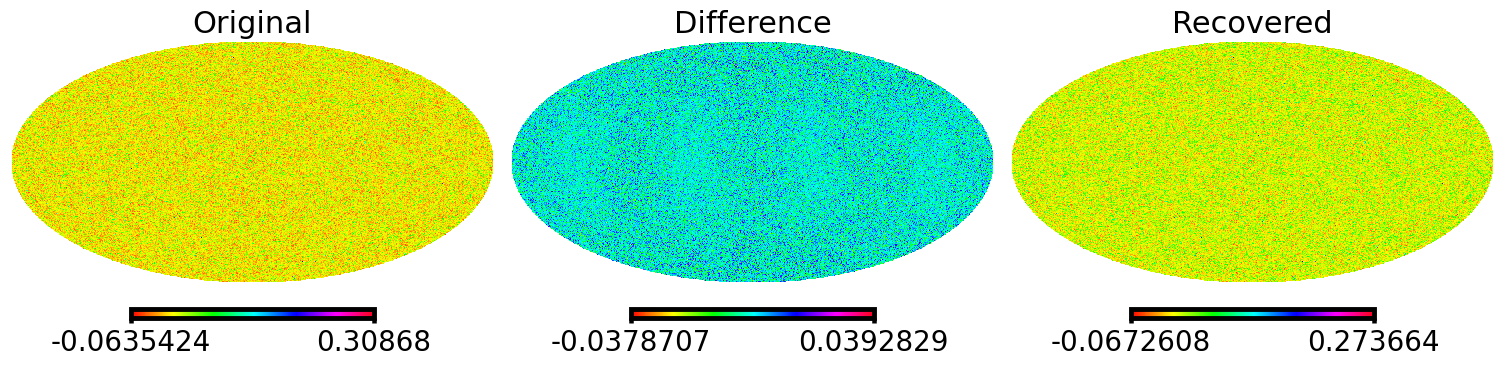

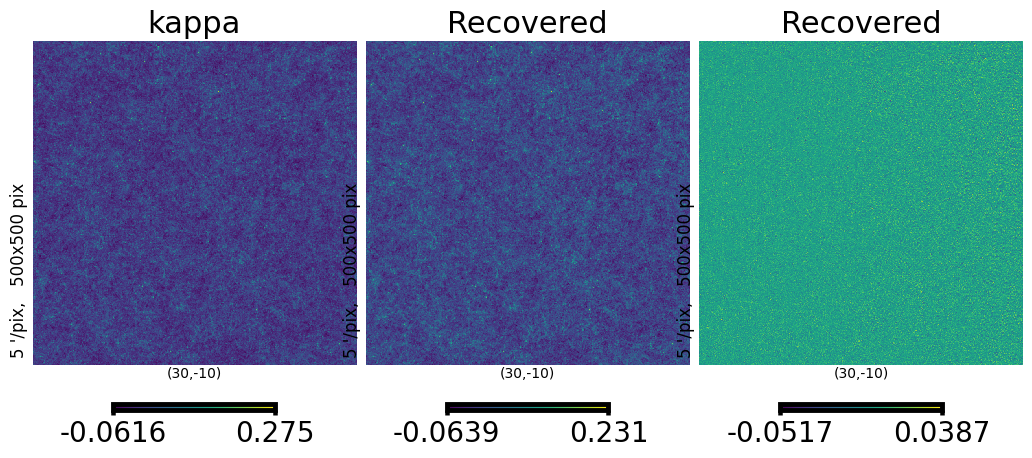

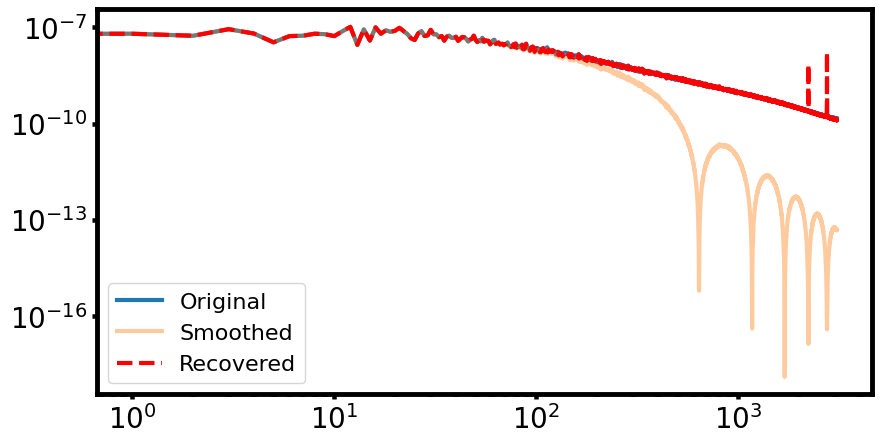

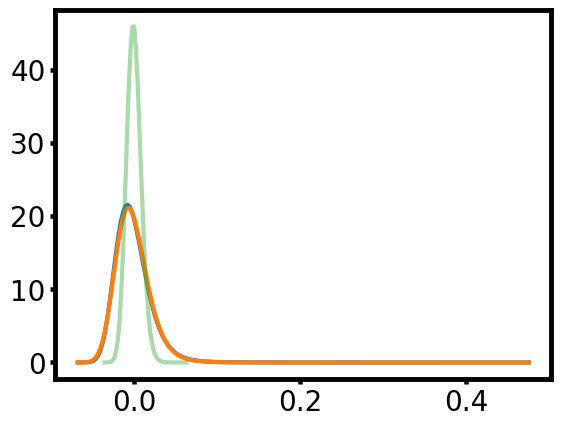

In [4]:
def wiener_deconvolution(kappa_smooth, beam, theory_cls, lmax, nside, noise_cls=None, reg_param=1e-4):
    """
    Perform Wiener deconvolution on a HEALPix map with regularization.

    Parameters:
    - kappa_smooth: Filtered map to deconvolve (input HEALPix map).
    - beam: Beam function (B_l).
    - theory_cls: Theoretical signal power spectrum (C_l^signal).
    - lmax: Maximum multipole moment.
    - nside: HEALPix resolution parameter.
    - noise_cls: Optional noise power spectrum (N_l). Default is zeros.
    - reg_param: Regularization parameter to stabilize deconvolution (default: 1e-4).
    
    Returns:
    - kappa_deconv: Deconvolved HEALPix map.
    """
    # Set noise power spectrum to zero if not provided
    if noise_cls is None:
        noise_cls = np.zeros(lmax + 1)

    # Compute spherical harmonics of the smoothed map
    alm_smooth = hp.map2alm(kappa_smooth, lmax=lmax)

    # Regularization to prevent instability (small epsilon in denominator)
    epsilon = reg_param * np.max(theory_cls)  # Scale reg_param relative to the max signal power spectrum

    # Compute Wiener filter in harmonic space with regularization
    wiener_filter = beam / (beam**2 + noise_cls / theory_cls + epsilon)

    # Apply Wiener filter to the smoothed alm
    alm_deconv = hp.almxfl(alm_smooth, wiener_filter)

    # Convert back to HEALPix map
    kappa_deconv = hp.alm2map(alm_deconv, nside, lmax=lmax)

    return kappa_deconv

filename = "/feynman/work/dap/lcs/vt272285/data/sim_data/Takahashi/allskymap_nres12r000.zs25.mag.dat"
kappa_original = load_takahashi_file(filename)

nside_target = 1024
lmax_target = 3*nside_target +1
pixres = hp.nside2resol(nside_target, arcmin=True)

print(hp.nside2resol(nside_target, arcmin=True))
kappa = downgrage_map(kappa_original, nside_target)

def get_beam(theta, lmax):
    """Compute a top-hat beam function in harmonic space."""
    def top_hat(b, radius):
        return np.where(np.abs(b) <= radius, 1 / (np.cos(radius) - 1) / (-2 * np.pi), 0)

    t = theta * np.pi / (60 * 180)  # Convert arcminutes to radians
    b = np.linspace(0.0, t * 1.2, 10000)
    bw = top_hat(b, t)
    return hp.sphtfunc.beam2bl(bw, b, lmax)  

beam = get_beam(pixres*6, lmax_target)
alm_coarse = hp.map2alm(kappa, lmax=lmax_target)
alm_smooth = hp.almxfl(alm_coarse, beam)
kappa_smooth = hp.alm2map(alm_smooth, nside_target, lmax=lmax_target)

pw, ells = get_pixel_wf_ells(nside_target, lmax_target)
kappa_cls = get_cls(kappa, lmax_target)

kappa_recovered = wiener_deconvolution(
    kappa_smooth=kappa_smooth,
    beam=beam,
    theory_cls=kappa_cls,
    lmax=lmax_target,
    nside=nside_target,
    noise_cls=None, reg_param=1e-3 )

kappa_smooth_cls = get_cls(kappa_smooth, lmax_target)
kappa_recovered_cls = get_cls(kappa_recovered, lmax_target)

plt.figure(figsize=(15,5))
hp.mollview(kappa, title='Original', sub=(1, 3, 1), cmap='hsv')
hp.mollview(kappa - kappa_recovered, title='Difference', sub=(1, 3, 2), cmap='hsv')
hp.mollview(kappa_recovered, title='Recovered', sub=(1, 3, 3), cmap='hsv')

plt.figure(figsize=(10,5))
hp.gnomview(kappa, rot=(30, -10), reso=5, xsize=500, title="kappa", sub=(1, 3, 1))
hp.gnomview(kappa_recovered, rot=(30, -10), reso=5, xsize=500, title="Recovered", sub=(1, 3, 2))
hp.gnomview(kappa_recovered - kappa, rot=(30, -10), reso=5, xsize=500, title="Recovered", sub=(1, 3, 3))  

plt.figure(figsize=(10,5))
plt.loglog(ells, kappa_cls, label='Original')
plt.loglog(ells, kappa_smooth_cls, label='Smoothed',alpha=0.4)
plt.loglog(ells, kappa_recovered_cls, label='Recovered', linestyle='--', c='r')
plt.legend()
plt.show()

counts_kappa, edges = np.histogram(kappa, bins=200, density=True)
counts_kappa_smooth, edges_smooth = np.histogram(kappa_smooth, bins=200, density=True)
counts_kappa_recovered, _ = np.histogram(kappa_recovered, bins=edges, density=True)

plt.plot(edges[:-1], counts_kappa, label='Original')
plt.plot(edges[:-1], counts_kappa_recovered, label='Recovered')
plt.plot(edges_smooth[:-1], counts_kappa_smooth, label='Smoothed', alpha=0.4)
plt.show()


nside:4096 npix:201326592
file opened!
3.435486411817406


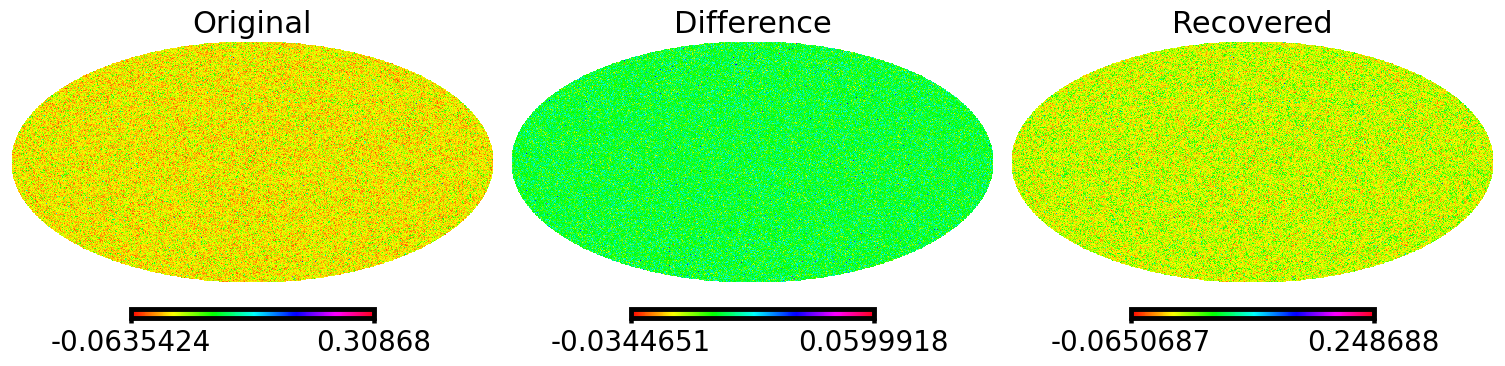

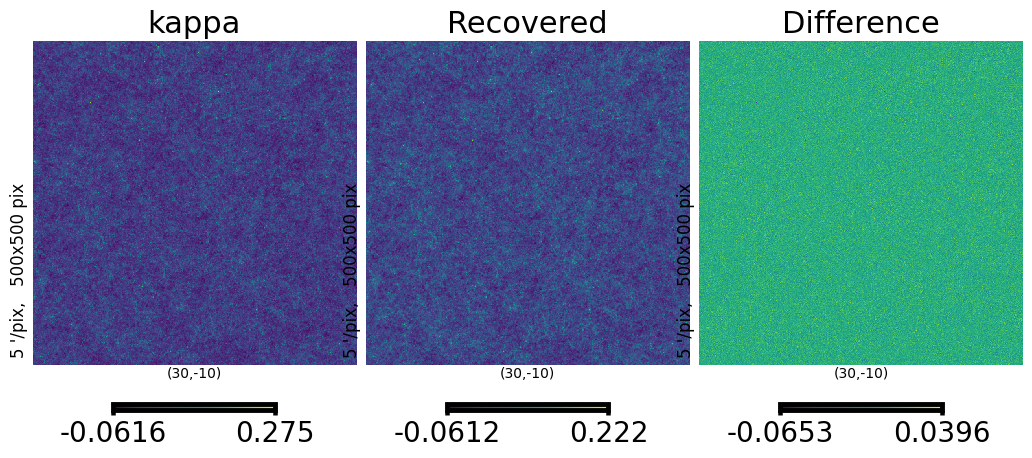

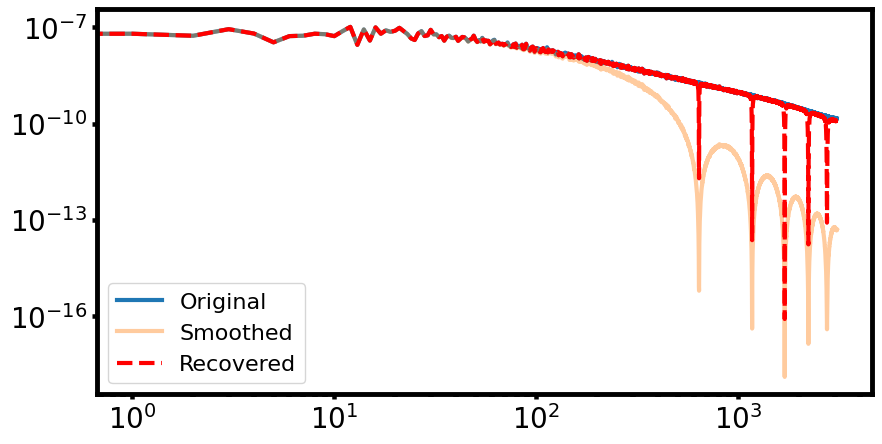

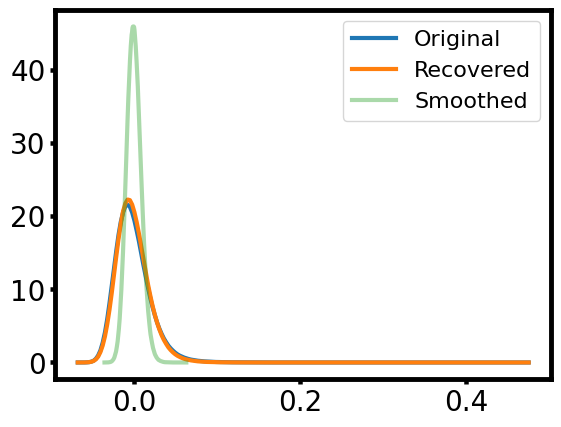

In [5]:
def tikhonov_deconvolution(kappa_smooth, beam, lmax, nside, regularization=1e-3):
    """
    Perform Tikhonov deconvolution on a HEALPix map.

    Parameters:
    - kappa_smooth: Filtered map to deconvolve (input HEALPix map).
    - beam: Beam function (B_l).
    - lmax: Maximum multipole moment.
    - nside: HEALPix resolution parameter.
    - regularization: Regularization parameter (lambda).

    Returns:
    - kappa_deconv: Deconvolved HEALPix map.
    """
    # Compute spherical harmonics of the smoothed map
    alm_smooth = hp.map2alm(kappa_smooth, lmax=lmax)

    # Apply Tikhonov regularization in harmonic space
    tikhonov_filter = beam / (beam**2 + regularization)
    alm_deconv = hp.almxfl(alm_smooth, tikhonov_filter)

    # Convert back to HEALPix map
    kappa_deconv = hp.alm2map(alm_deconv, nside, lmax=lmax)
    
    return kappa_deconv

filename = "/feynman/work/dap/lcs/vt272285/data/sim_data/Takahashi/allskymap_nres12r000.zs25.mag.dat"
kappa_original = load_takahashi_file(filename)

nside_target = 1024
lmax_target = 3*nside_target +1
pixres = hp.nside2resol(nside_target, arcmin=True)

print(hp.nside2resol(nside_target, arcmin=True))
kappa = downgrage_map(kappa_original, nside_target)

def get_beam(theta, lmax):
    """Compute a top-hat beam function in harmonic space."""
    def top_hat(b, radius):
        return np.where(np.abs(b) <= radius, 1 / (np.cos(radius) - 1) / (-2 * np.pi), 0)

    t = theta * np.pi / (60 * 180)  # Convert arcminutes to radians
    b = np.linspace(0.0, t * 1.2, 10000)
    bw = top_hat(b, t)
    return hp.sphtfunc.beam2bl(bw, b, lmax)  

beam = get_beam(pixres*6, lmax_target)
alm_coarse = hp.map2alm(kappa, lmax=lmax_target)
alm_smooth = hp.almxfl(alm_coarse, beam)
kappa_smooth = hp.alm2map(alm_smooth, nside_target, lmax=lmax_target)

pw, ells = get_pixel_wf_ells(nside_target, lmax_target)
kappa_cls = get_cls(kappa, lmax_target)

kappa_recovered = tikhonov_deconvolution(
    kappa_smooth=kappa_smooth,
    beam=beam,
    lmax=lmax_target,
    nside=nside_target,
   regularization=1e-5 )

kappa_smooth_cls = get_cls(kappa_smooth, lmax_target)
kappa_recovered_cls = get_cls(kappa_recovered, lmax_target)

plt.figure(figsize=(15,5))
hp.mollview(kappa, title='Original', sub=(1, 3, 1), cmap='hsv')
hp.mollview(kappa - kappa_recovered, title='Difference', sub=(1, 3, 2), cmap='hsv')
hp.mollview(kappa_recovered, title='Recovered', sub=(1, 3, 3), cmap='hsv')

plt.figure(figsize=(10,5))
hp.gnomview(kappa, rot=(30, -10), reso=5, xsize=500, title="kappa", sub=(1, 3, 1))
hp.gnomview(kappa_recovered, rot=(30, -10), reso=5, xsize=500, title="Recovered", sub=(1, 3, 2))
hp.gnomview(kappa_recovered - kappa, rot=(30, -10), reso=5, xsize=500, title="Difference", sub=(1, 3, 3))  

plt.figure(figsize=(10,5))
plt.loglog(ells, kappa_cls, label='Original')
plt.loglog(ells, kappa_smooth_cls, label='Smoothed',alpha=0.4)
plt.loglog(ells, kappa_recovered_cls, label='Recovered', linestyle='--', c='r')
plt.legend()
plt.show()

counts_kappa, edges = np.histogram(kappa, bins=200, density=True)
counts_kappa_smooth, edges_smooth = np.histogram(kappa_smooth, bins=200, density=True)
counts_kappa_recovered, _ = np.histogram(kappa_recovered, bins=edges, density=True)

plt.plot(edges[:-1], counts_kappa, label='Original')
plt.plot(edges[:-1], counts_kappa_recovered, label='Recovered')
plt.plot(edges_smooth[:-1], counts_kappa_smooth, label='Smoothed', alpha=0.4)
plt.legend()
plt.show()

